# CNN Model (Object Detection)- Tensorflow

## X-ray Airport Prohibited Items Computer Vision Project 

### overview:


- The dataset contains 5806 Images
- It is defined into 5 classes: Gun, Knife, Pliers, Scissors, Wrench 
- TXT annotations

## The objective:
- Build architecture of CNN from scratch via TensorFlow
- The dataset will be used for a Computer Vision Project that aims to detect Prohibited Items.

# Object Detection model


- We will use the Tensorflow object detection model from scratch because it reliably generates models quickly and easily.


### Check The version of TensorFlow Installed

In [2]:
!python --version
import os

import tensorflow as tf
print("\nTensoflow version = "+tf.__version__)


Python 3.11.5

Tensoflow version = 2.15.0


# Step 1:  Import data and display image
- The provided code utilizes the os module to gather the file paths of all '.jpg' files in a specified directory through iteration.
- Count the total number of images in the dataset.

In [3]:
import os


data_dir_path = r"C:\Users\beaut\Downloads\X-ray_yolov8\train\images"
image_files = [os.path.join(data_dir_path, file) for file in os.listdir(data_dir_path) if file.endswith('.jpg')]

#To determine the number of image files in a list, this code will output the length of the list.
print(len(image_files))

5806


### Display an example image

In [4]:
# import OpenCV (cv2), numpy and Matplotlib
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt


C:\Users\beaut\Downloads\X-ray_yolov8\train\images\P00065_jpg.rf.d9c998ac2220ca0e33e8742cdad0ca74.jpg


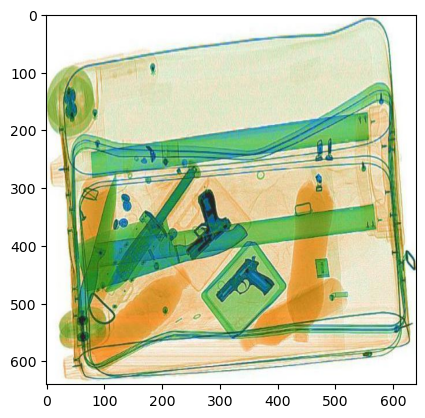

In [5]:
# Example image of X-ray baggage detection

sample_img_path = str(image_files[50])
print(sample_img_path)
sample_img = cv.imread(sample_img_path, cv.IMREAD_COLOR)
plt.imshow(cv.cvtColor(sample_img, cv.COLOR_BGR2RGB))
plt.show()

### Example of annotation coordinates


In [6]:
# open and read the contents of a annotation text file 
sample_annotation_path = sample_img_path[0:-4] + '.txt'
with open(sample_annotation_path) as f:
    print(f.readlines())

['0 0.4140625 0.5640625 0.221875 0.203125\n', '0 0.5421875 0.73203125 0.1875 0.17421875\n', '1 0.2875 0.5796875 0.290625 0.3640625\n', '1 0.1421875 0.61953125 0.1421875 0.37734375\n', '1 0.3046875 0.6171875 0.5 0.271875']


# Step Two: Data preprocessing

- Check that the annotated file and the image are both present
- Split the data into Training, Validation, and Testing
- Resize the images 
- Combined images and annotations
- Normalize the images 

In [7]:
'''
This function used to split files, such as images and corresponding annotation files, into separate sets for machine learning tasks, 
including training, validation, and testing.
'''

import os
import random

def list_files(full_data_path, image_ext='.jpg', split_percentage=[70, 20]):
    files = []
    discarded = 0
    object_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}  # Initialize object counts

    for file in os.listdir(full_data_path):
        if file.endswith(".txt"):
            with open(os.path.join(full_data_path, file), 'r') as fp:
                lines = fp.readlines()
                if len(lines) > 1:
                    discarded += 1
                    continue

            strip = file[:len(file) - len(".txt")]
            image_path = os.path.join(full_data_path, strip + image_ext)
            if os.path.isfile(image_path):
                class_label = int(lines[0][0])  # Get the class label
                if class_label in object_counts:
                    object_counts[class_label] += 1
                files.append(strip)

    size = len(files)
    print(str(discarded) + " file(s) discarded")
    print(str(size) + " valid case(s)")
    print(str(object_counts) + " object counts")

    random.shuffle(files)

    split_training = int(split_percentage[0] * size / 100)
    split_validation = split_training + int(split_percentage[1] * size / 100)

    return files[0:split_training], files[split_training:split_validation], files[split_validation:]

In [8]:
full_data_path = r"C:\Users\beaut\Downloads\X-ray_yolov8\train\images"
training_files, validation_files, test_files = list_files(full_data_path)

print(str(len(training_files)) + " Training file")
print(str(len(validation_files)) + " Validation file")
print(str(len(test_files)) + " Test file")

2880 file(s) discarded
2926 valid case(s)
{0: 593, 1: 270, 2: 1142, 3: 568, 4: 353} object counts
2048 Training file
585 Validation file
293 Test file


### Resize the images:
- An image and a bounding box as input and resizes them to a specified input size.

In [9]:
input_size = 244

def format_image(img, box):
    height, width = img.shape 
    max_size = max(height, width) 
    r = max_size / input_size 
    new_width = int(width / r) 
    new_height = int(height / r) 
    new_size = (new_width, new_height) 
    # array of zeros with = (input_size, input_size), then we resize the image and past it on the array of zeros:
    resized = cv.resize(img, new_size, interpolation= cv.INTER_LINEAR) #resized.shape
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    x, y, w, h = box[0], box[1], box[2], box[3]
    new_box = [int((x - 0.5*w)* width / r), int((y - 0.5*h) * height / r), int(w*width / r), int(h*height / r)]

    return new_image, new_box

### Combined images and annotations (One object)

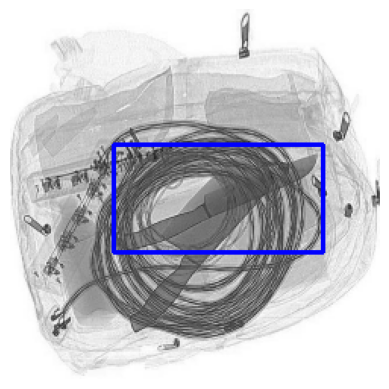

In [10]:
#image file path 
temp_img = cv.imread(r"C:\Users\beaut\Downloads\X-ray_yolov8\train\images\P00001_jpg.rf.faeba46354cdb44ccec6b366232caf86.jpg", cv.IMREAD_GRAYSCALE)
# annotation 
temp_box = [0.565625, 0.5171875, 0.5703125, 0.296875]

temp_img_formated, box = format_image(temp_img, temp_box)

temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB) #change to RGB to grayscale 

cv.rectangle(temp_color_img, box, (0, 0, 255), 2)

plt.imshow(temp_color_img)
plt.axis("off")
plt.show()

###  Combined images and annotations (many objects)

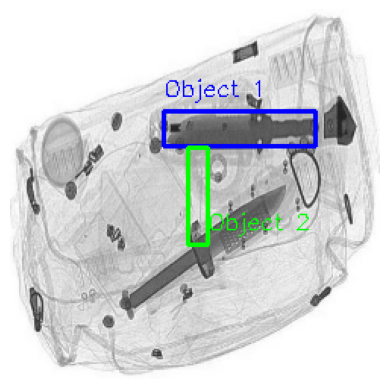

In [11]:
import cv2 as cv
import matplotlib.pyplot as plt

# Load the image
temp_img = cv.imread(r"C:\Users\beaut\Downloads\X-ray_yolov8\train\images\P00054_jpg.rf.49f88ea44c5ef65036a80f90376f720a.jpg", cv.IMREAD_GRAYSCALE)

# Define the first bounding box and its annotation
temp_box1 = [0.625, 0.32578125, 0.415625, 0.09921875]
annotation1 = "Object 1"

# Define the second bounding box and its annotation
temp_box2 = [0.5328125, 0.6359375, 0.4828125, 0.3765625]
annotation2 = "Object 2"

# Format the image and the first bounding box
temp_img_formated, box1 = format_image(temp_img, temp_box1)

# Convert the formatted image to color (assuming RGB)
temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB)

# Draw the first bounding box and its annotation
cv.rectangle(temp_color_img, box1, (0, 0, 255), 2)
cv.putText(temp_color_img, annotation1, (box1[0], box1[1] - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

# Calculate the coordinates of the second bounding box
box2 = [
    int(temp_color_img.shape[1] * temp_box2[0]),
    int(temp_color_img.shape[0] * temp_box2[1]),
    int(temp_color_img.shape[1] * temp_box2[2]),
    int(temp_color_img.shape[0] * temp_box2[3])
]

# Draw the second bounding box and its annotation
cv.rectangle(temp_color_img, (box2[0], box2[1]), (box2[2], box2[3]), (0, 255, 0), 2)
cv.putText(temp_color_img, annotation2, (box2[0], box2[1] - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

# Display the image with bounding boxes and annotations
plt.imshow(temp_color_img)
plt.axis("off")
plt.show()

- It shows the second object hasn't a right Coordinates

### Normalize the images.

- In this function, images are resized, normalized, and paired with their corresponding labels
in a format suitable for training deep learning models.


In [19]:
def data_load(files, full_data_path = r"C:\Users\beaut\Downloads\X-ray_yolov8\train\images" , image_ext = ".jpg"):
    X = [] #images after resize and normalize
    Y = [] #coordinates and labels

    for file in files:
        img = cv.imread(os.path.join(full_data_path, file + image_ext), cv.IMREAD_GRAYSCALE)

        k = 1

        with open(full_data_path + "/" + file + ".txt", 'r') as fp: 
            line = fp.readlines()[0]
            if line[0] == '0':
                k = 0

            box = np.array(line[1:].split(), dtype=float)

        img, box = format_image(img, box)
        img = img.astype(float) / 255. #normalize the image
        box = np.asarray(box, dtype=float) / input_size #normalize the coordinates because 'format_image' will return real values of coordinates
        label = np.append(box, k) #label will contain: [coordinates,label]

        X.append(img)
        Y.append(label)

    X = np.array(X) #Tensorflow expects an array of NumPy values as input
    
    X = np.expand_dims(X, axis=3) #add new dimension for the label
    
    X = tf.convert_to_tensor(X, dtype=tf.float32) #Transform the images array into a tensor.

    Y = tf.convert_to_tensor(Y, dtype=tf.float32) #Transform the label array into a tensor.
    
    result = tf.data.Dataset.from_tensor_slices((X, Y)) # zip the image and it's label as one tensor.
    

    return result

In [20]:
#invokes the data_load function with the training_files list
raw_train_ds = data_load(training_files)


In [21]:
#invokes the data_load function with the validation list

raw_validation_ds = data_load(validation_files)


In [22]:
#invokes the data_load function with the test list

raw_test_ds = data_load(test_files)


In [23]:

'''
The tf.one_hot function converts a label into a one-hot encoded vector based on the specified number of
classes (CLASSES)..
'''

def format_instance(image, label):
    return image, (tf.one_hot(int(label[4]), CLASSES), [label[0], label[1], label[2], label[3]])

'''
Function formats image and label. Label converted to one-hot vector for classification.
Bounding box coordinates returned separately.
'''

'\nFunction formats image and label. Label converted to one-hot vector for classification.\nBounding box coordinates returned separately.\n'

In [26]:
# set a number of classes
CLASSES = 5
def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE) #TensorFlow to automatically determine the number of parallel calls 
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True) #shuffle the elements of the dataset. 
    dataset = dataset.repeat() # The dataset be repeated indefinitely.
    dataset = dataset.batch(BATCH_SIZE) #specifies the size of each batch.
    dataset = dataset.prefetch(tf.data.AUTOTUNE) #prefetch data elements from the dataset, allowing for improved performance
    return dataset

In [28]:
BATCH_SIZE = 128

train_ds = tune_training_ds(raw_train_ds)

In [29]:
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(validation_files) // 4)
    dataset = dataset.repeat()
    return dataset

In [30]:
validation_ds = tune_validation_ds(raw_validation_ds)


### Visualization of images with their corresponding bounding box annotations

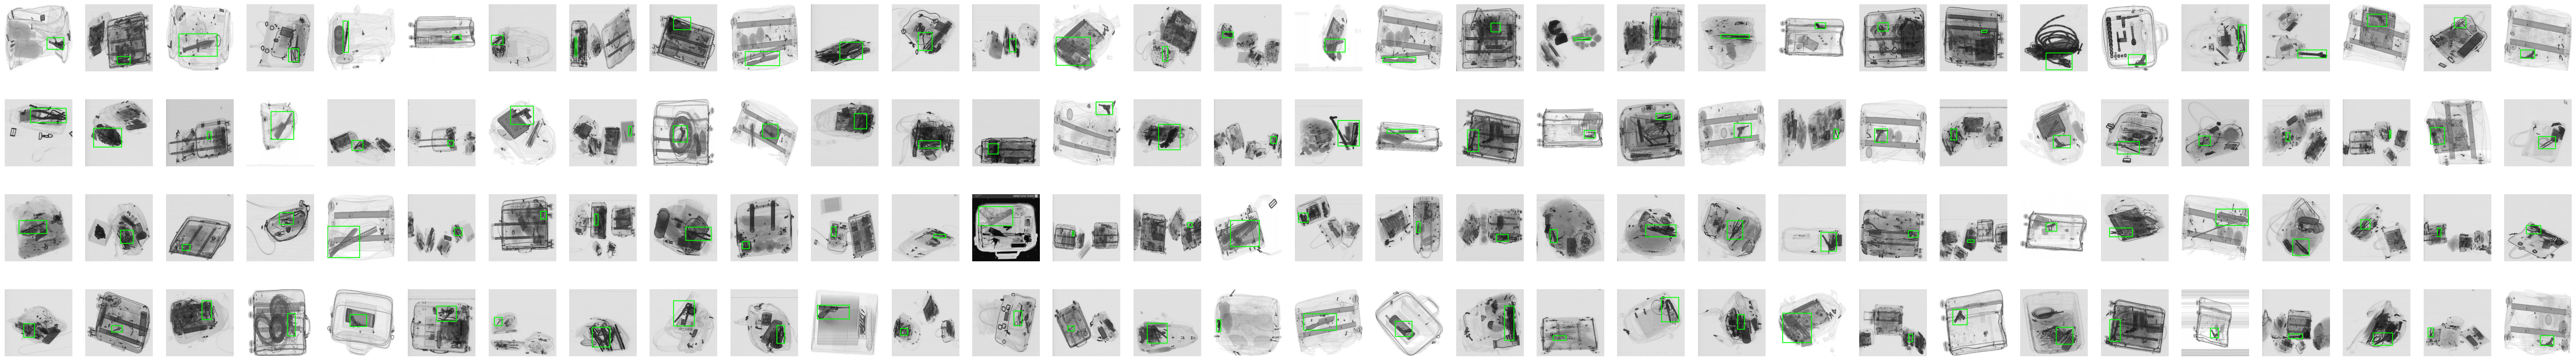

In [31]:
plt.figure(figsize=(70, 10))
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(4, BATCH_SIZE//4, i + 1)
        label = labels[0][i]
        box = (labels[1][i] * input_size)
        box = tf.cast(box, tf.int32)

        image = images[i].numpy().astype("float") * 255.0
        image = image.astype(np.uint8)
        image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

        color = (0, 255, 0)  # Set annotation color to green

        cv.rectangle(image_color, box.numpy(), color, 2)

        plt.imshow(image_color)
        plt.axis("off")
plt.show()

# Step 3: Build CNN Modeling 
- This architecture is designed for a multi-task learning scenario where the model needs to perform both classification and regression tasks

## The model is built in the following way:

### Feature Extractor:

- Extracts important features from the input data.
- Comprises multiple convolutional layers with ReLU activation, followed by average pooling.
- The last convolutional layer includes a dropout layer to prevent overfitting by randomly dropping out a portion of the learned features.

### Model Adaptor:

- Takes the output of the feature extractor and prepares it for subsequent tasks.
- Flattens the feature maps into a 1D vector.
- Includes a fully connected dense layer with ReLU activation to further process and refine the extracted features.

### Classifier Head:

- Uses the output from the model adaptor to perform classification.
- Consists of a fully connected dense layer with softmax activation.
- The number of units in this layer is determined by the value of the CLASSES variable, representing the number of classes for classification.

### Regressor Head:

- Uses the output from the model adaptor to perform regression.
- Comprises a fully connected dense layer with no activation function.
- The layer has 4 units, indicating that it aims to predict 4 continuous values.

### Model Compilation:

- The model is compiled using the Adam optimizer.
- The loss function for the classifier head is categorical cross-entropy, while the regressor head uses mean squared error.
- Evaluation metrics for the classifier head are accuracy, and for the regressor head, it is mean squared error.

In [33]:
DROPOUT_FACTOR = 0.5




def build_feature_extractor(inputs):

    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(input_size, input_size, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    return x

def build_model_adaptor(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x

def build_regressor_head(inputs):
    return tf.keras.layers.Dense(units = '4', name = 'regressor_head')(inputs)

def build_classifier_head(inputs):
    return tf.keras.layers.Dense(CLASSES, activation='softmax', name = 'classifier_head')(inputs)



def build_model(inputs):
    
    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' }, 
              metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })

    return model

In [34]:
model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)))
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 244, 244, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 242, 242, 16)         160       ['input_1[0][0]']             
                                                                                                  
 average_pooling2d (Average  (None, 121, 121, 16)         0         ['conv2d[0][0]']              
 Pooling2D)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 119, 119, 32)         4640      ['average_pooling2d[0][0]

### Visualization the architecture

In [35]:
!pip install pydot

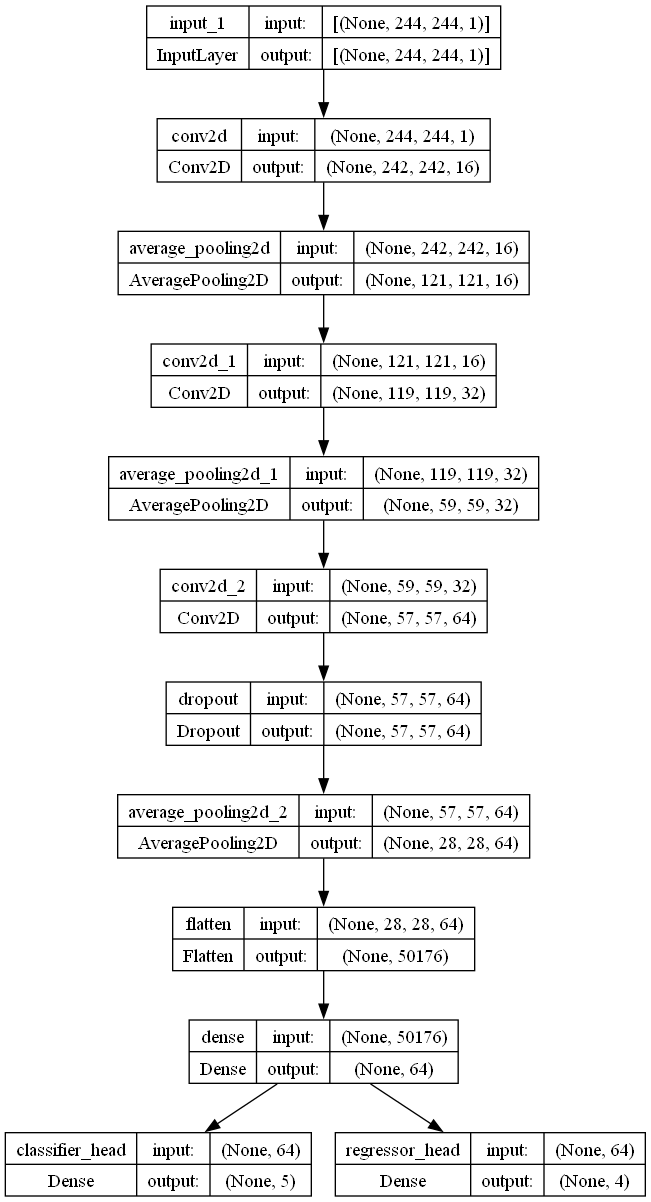

In [36]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

- The model has a total of 3,235,209 parameters, which means it has a significant number of learnable weights. All of these parameters are trainable

### Train Model 

In [37]:

EPOCHS = 10

history = model.fit(train_ds,
                    steps_per_epoch=(len(training_files) // BATCH_SIZE),
                    validation_data=validation_ds, validation_steps=1, 
                    epochs=EPOCHS,
                    verbose=1)

Epoch 1/10


16/16 [==============================] - 29s 2s/step - loss: 0.7203 - classifier_head_loss: 0.6606 - regressor_head_loss: 0.0596 - classifier_head_accuracy: 0.7520 - regressor_head_mse: 0.0596 - val_loss: 0.5190 - val_classifier_head_loss: 0.4845 - val_regressor_head_loss: 0.0345 - val_classifier_head_accuracy: 0.8082 - val_regressor_head_mse: 0.0345
Epoch 2/10
16/16 [==============================] - 23s 1s/step - loss: 0.4528 - classifier_head_loss: 0.4201 - regressor_head_loss: 0.0327 - classifier_head_accuracy: 0.8057 - regressor_head_mse: 0.0327 - val_loss: 0.3735 - val_classifier_head_loss: 0.3357 - val_regressor_head_loss: 0.0378 - val_classifier_head_accuracy: 0.8219 - val_regressor_head_mse: 0.0378
Epoch 3/10
16/16 [==============================] - 26s 2s/step - loss: 0.3661 - classifier_head_loss: 0.3358 - regressor_head_loss: 0.0303 - classifier_head_accuracy: 0.8589 - regressor_head_mse: 0.0303 - val_loss: 0.3476 - val_classifier_head_loss: 0.3176 - val_regres

## Plots the training and validation accuracy values:

- The code snippet provided plots the training and validation accuracy for the classifier head.

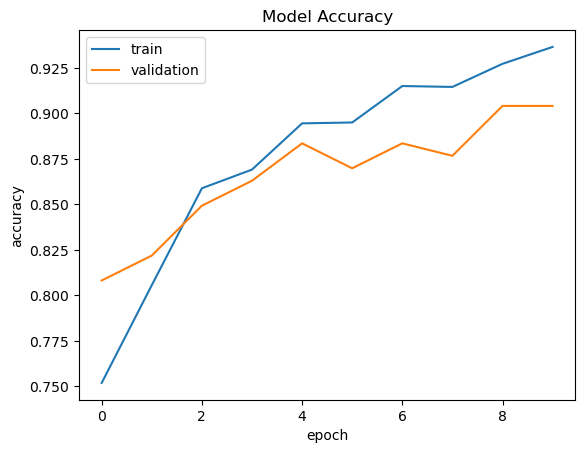

In [41]:
plt.plot(history.history['classifier_head_accuracy'])
plt.plot(history.history['val_classifier_head_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##  plots the training and validation loss
- The code snippet you provided plots the training and validation loss values for the classifier head during the training process

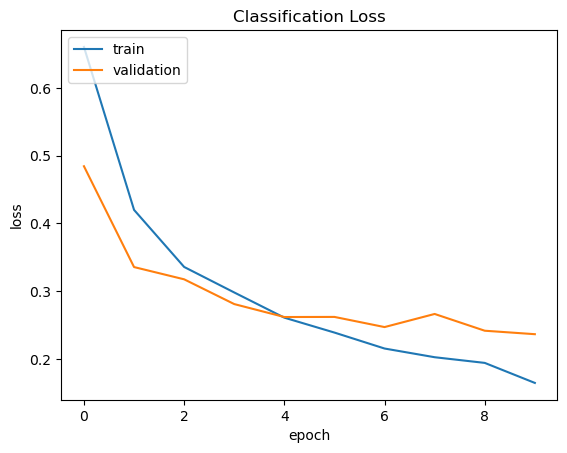

In [42]:
plt.plot(history.history['classifier_head_loss'])
plt.plot(history.history['val_classifier_head_loss'])
plt.title('Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Plots (bounding box loss)

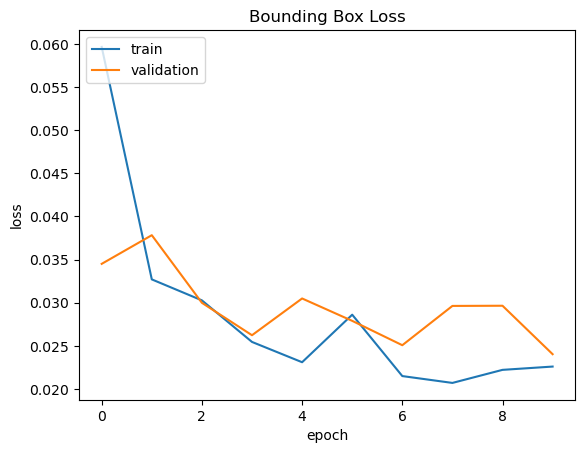

In [40]:
plt.plot(history.history['regressor_head_loss'])
plt.plot(history.history['val_regressor_head_loss'])
plt.title('Bounding Box Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### calculates the intersection over union (IoU) between two bounding boxes.
- The intersection_over_union function can be used to measure the overlap between two bounding boxes, which is commonly used in object detection and evaluation tasks.

In [43]:
# adapted from: https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def intersection_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
    boxBArea = (boxB[2] + 1) * (boxB[3] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# Step 5:  prepare for testing
- The task involves marking a box as green/blue if the predicted label match the actual label.
- Blue indicate actual boundary box
- Green indicate actual boundary box

In [44]:
def tune_test_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1) 
    dataset = dataset.repeat()
    return dataset

test_ds = tune_test_ds(raw_test_ds)

20


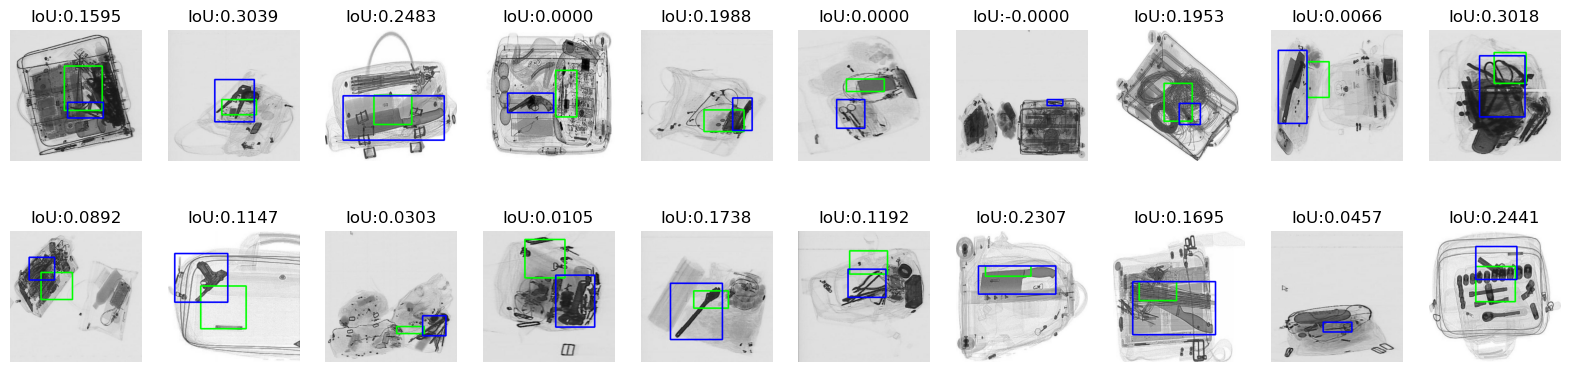

In [45]:
plt.figure(figsize=(20, 10))

test_list = list(test_ds.take(20).as_numpy_iterator())

print(len(test_list))

image, labels = test_list[0]

for i in range(len(test_list)):

    ax = plt.subplot(4, 10, i + 1)
    image, labels = test_list[i]
    aaa = type(image)
    predictions = model(image)

    predicted_box = predictions[1][0] * input_size
    predicted_box = tf.cast(predicted_box, tf.int32)

    predicted_label = predictions[0][0]

    image = image[0]

    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)

    image = image.astype("float") * 255.0
    image = image.astype(np.uint8)
    image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)



    cv.rectangle(image_color, predicted_box.numpy(), color, 2)
    cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)

    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())

    plt.title("IoU:" + format(IoU, '.4f'))
    plt.imshow(image_color)
    plt.axis("off")

In [37]:
import os
import tensorflow as tf

# Create a directory to save the model
os.makedirs('object-detection\\my_model', exist_ok=True)

# Save the model
model.save('object-detection\\my_model')

INFO:tensorflow:Assets written to: object-detection\my_model\assets


INFO:tensorflow:Assets written to: object-detection\my_model\assets
